In [2]:
# coding:utf-8
import pandas as pd
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif'] = ['KaiTi'] # 指定默认字体
# plt.rcParams['axes.unicode_minus'] = False
from ncov.reader import get_data,watch_data
import statsmodels.tsa.api as smt    
from statsmodels.tsa.stattools import adfuller
import torch
from torch.nn.parameter import Parameter
import torch.optim as optim
import os
import pickle
torch.set_default_tensor_type(torch.DoubleTensor)
import warnings
warnings.filterwarnings('ignore')

In [3]:
# class SEIR_cell(torch.nn.Module):
#     def __init__(self, N, beta_init, gamma_2_init, theta_init):
#         super(SEIR_cell, self).__init__()
#         # self.date_len = date_len
#         self.beta = Parameter(torch.tensor([beta_init], requires_grad=True))
#         self.N = Parameter(torch.tensor([N], requires_grad=True))
#         self.gamma_1 = 0.
#         self.gamma_2 = Parameter(torch.tensor([gamma_2_init], requires_grad=True))
#         self.alpha = 1.
#         self.theta = Parameter(torch.tensor([theta_init], requires_grad=True))
#         # self.E_ratio = Parameter(torch.tensor([3.], requires_grad=True))

#     def clamp(self, X):
#         # return torch.clamp(X, min=0, max=self.N)
#         return X

#     def forward(self, X):
#         S, confirm, Exposed, recover, dead = X
#         # self.beta = beta_old + self.beta_add
#         # self.gamma_2 = gamma_2_old + self.gamma_2_add
#         S_rest = self.clamp(S - self.beta*confirm*S/self.N) # dS/dt
#         E = self.clamp(Exposed + self.beta*confirm*S/self.N - self.alpha*Exposed) # dE/dt

#         # I = self.clamp(confirm + self.alpha*Exposed - self.gamma_2*confirm - self.theta*confirm) # dI/dt
#         # R = self.clamp(recover + self.gamma_2*confirm) # dR/dt
#         # D = self.clamp(dead + self.theta*confirm)
#         I = self.clamp(confirm + self.alpha*E - self.gamma_2*confirm - self.theta*confirm) # dI/dt
#         R = self.clamp(recover + self.gamma_2*I) # dR/dt
#         D = self.clamp(dead + self.theta*I)

#         return S_rest, I, E, R, D, self.beta, self.gamma_2, self.theta, self.N


In [4]:
class SEIR_cell(torch.nn.Module):
    def __init__(self, N, beta_init=0.2586, gamma_2_init=0.018, theta_init=0.001, alpha_init=0.2):
        super(SEIR_cell, self).__init__()
        # self.date_len = date_len
        self.beta = Parameter(torch.tensor([beta_init], requires_grad=True))
        self.N = Parameter(torch.tensor([N], requires_grad=False))
        self.gamma_2 = Parameter(torch.tensor([gamma_2_init], requires_grad=True))
        # self.gamma_2 = Parameter(torch.tensor([0.5], requires_grad=True))
        self.alpha = Parameter(torch.tensor([alpha_init], requires_grad=True))
        self.theta = Parameter(torch.tensor([theta_init], requires_grad=True))
        # self.theta = Parameter(torch.tensor([0.2], requires_grad=True))
        # self.E_ratio = Parameter(torch.tensor([3.], requires_grad=True))

    def clamp(self, X):
        # return torch.clamp(X, min=0, max=self.N)
        return X

    def act(self, X):
        return torch.pow(X,2)

    def forward(self, X):
        S, confirm, Exposed, recover, dead = X
        # self.beta = beta_old + self.beta_add
        # self.gamma_2 = gamma_2_old + self.gamma_2_add
        S_rest = S - self.act(self.beta)*confirm*S/self.N # dS/dt
        E = Exposed + self.act(self.beta)*confirm*S/self.N - self.act(self.alpha)*Exposed # dE/dt

        I = confirm + self.act(self.alpha)*Exposed - self.act(self.gamma_2)*confirm - self.act(self.theta)*confirm # dI/dt
        R = recover + self.act(self.gamma_2)*confirm # dR/dt
        D = dead + self.act(self.theta)*confirm

        # I = confirm + self.act(self.alpha)*E - self.act(self.gamma_2)*confirm - self.act(self.theta)*confirm # dI/dt
        # R = recover + self.act(self.gamma_2)*I # dR/dt
        # D = dead + self.act(self.theta)*I

        return S_rest, I, E, R, D, self.beta, self.gamma_2, self.theta, self.alpha
    
    def update_beta(self, b):
        self.beta = Parameter(torch.tensor([b], requires_grad=True))


In [34]:
class SEIR_model(torch.nn.Module):
    def __init__(self, date_len, pred_date_len=0, N=2870000., E_ratio_init=3., I_init=41, R_init=2., D_init=0., param={}):
        super(SEIR_model, self).__init__()
        self.SEIR_cells = torch.nn.ModuleList()
        self.SEIR_pred_cells = torch.nn.ModuleList()
        self.N = N
        self.E_ratio = E_ratio_init
        self.I = I_init
        self.E = (self.I * self.E_ratio)
        self.R = R_init
        self.D = D_init
        self.S = (self.N - self.I - self.E - self.R - self.D)
        self.date_len = date_len-1
        self.pred_date_len = pred_date_len
        if param!={}:
            len_param=len(param['beta'])
            self.beta_save = param['beta']
            self.gamma_2_save = param['gamma_2']
            self.alpha_save = param['alpha']
            self.theta_save = param['theta']
            for i in range(len_param):
                beta = self.beta_save[i]
                gamma_2 = self.gamma_2_save[i]
                alpha = self.alpha_save[i]
                theta = self.theta_save[i]
                self.SEIR_cells.append(SEIR_cell(self.N,beta,gamma_2,theta,alpha))
            if self.date_len>len_param:
                for i in range(len_param, self.date_len):
                    if len_param>=1:
                        beta = self.beta_save[len_param-1]
                        gamma_2 = self.gamma_2_save[len_param-1]
                        alpha = self.alpha_save[len_param-1]
                        theta = self.theta_save[len_param-1]
                        self.SEIR_cells.append(SEIR_cell(self.N,beta,gamma_2,theta,alpha)) 
                    else:
                        self.SEIR_cells.append(SEIR_cell(self.N)) 
        else:
            for i in range(self.date_len):
                self.SEIR_cells.append(SEIR_cell(self.N)) 

        self.S_tensor_cur = torch.zeros((self.date_len+1,))
        self.I_tensor_cur = torch.zeros((self.date_len+1,))
        self.E_tensor_cur = torch.zeros((self.date_len+1,))
        self.R_tensor_cur = torch.zeros((self.date_len+1,))
        self.D_tensor_cur = torch.zeros((self.date_len+1,))
        
    
    def forward(self, X):
        inp = self.S, self.I, self.E, self.R, self.D
        # param = beta_init, gamma_2_init
        S_tensor = torch.zeros((self.date_len+1,))
        I_tensor = torch.zeros((self.date_len+1,))
        E_tensor = torch.zeros((self.date_len+1,))
        R_tensor = torch.zeros((self.date_len+1,))
        D_tensor = torch.zeros((self.date_len+1,))
        S_tensor[0], I_tensor[0], E_tensor[0], R_tensor[0], D_tensor[0] = inp
        for i in range(self.date_len):
            if i == self.date_len-1: # we cannot update the last beta with grad
                self.beta = beta_cur
                self.SEIR_cells[i].update_beta(beta_cur)
            S, I, E, R, D, beta_cur, gamma_2_cur, theta_cur, alpha_cur = self.SEIR_cells[i](inp)
            S_tensor[i+1], I_tensor[i+1], E_tensor[i+1], R_tensor[i+1], D_tensor[i+1] = S, I, E, R, D
            self.beta = beta_cur
            self.gamma_2 = gamma_2_cur
            self.theta = theta_cur
            self.alpha = alpha_cur
            self.S_cur = S
            self.I_cur = I
            self.E_cur = E
            self.R_cur = R
            self.D_cur = D
            inp = [S, I, E, R, D]
        self.S_tensor_cur, self.I_tensor_cur, self.E_tensor_cur, self.R_tensor_cur, self.D_tensor_cur = S_tensor, I_tensor, E_tensor, R_tensor, D_tensor
        return S_tensor, I_tensor, E_tensor, R_tensor, D_tensor, beta_cur, gamma_2_cur

    def pred(self, pred_date_len, param={}):
        check_positive_replace = lambda x,y:y if x <=0 else x
        if param=={}:
            N_cur=self.N
            beta=self.beta
            gamma_2=self.gamma_2
            theta=self.theta
            alpha=self.alpha
        else:
            N_cur=self.N
            beta=check_positive_replace(param['beta'],self.beta)
            gamma_2=check_positive_replace(param['gamma_2'],self.gamma_2)
            theta=check_positive_replace(param['theta'],self.theta)
            alpha=check_positive_replace(param['alpha'],self.alpha)
        cur_pred_cells_len = len(self.SEIR_pred_cells)
        # print("cur_pred_cells_len:", cur_pred_cells_len)
        if cur_pred_cells_len!=pred_date_len:
            self.SEIR_pred_cells = torch.nn.ModuleList()
            for i in range(pred_date_len):
                self.SEIR_pred_cells.append(SEIR_cell(N_cur,beta,gamma_2,theta,alpha))
        S_pred_tensor = torch.zeros((pred_date_len,))
        I_pred_tensor = torch.zeros((pred_date_len,))
        E_pred_tensor = torch.zeros((pred_date_len,))
        R_pred_tensor = torch.zeros((pred_date_len,))
        D_pred_tensor = torch.zeros((pred_date_len,))
        # pred:
        inp = self.S_cur, self.I_cur, self.E_cur, self.R_cur, self.D_cur
        for i in range(pred_date_len):
            S, I, E, R, D, beta_, gamma_2_, theta_, alpha_ = self.SEIR_pred_cells[i](inp)
            S_pred_tensor[i], I_pred_tensor[i], E_pred_tensor[i], R_pred_tensor[i], D_pred_tensor[i] = S, I, E, R, D
            inp = [S, I, E, R, D]
        return S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor


    def beta_pred(self, beta_list):
        check_positive = lambda x:0 if x <=0 else np.sqrt(x)
        sqrt_datas=[beta_list]
        datas = [list(np.square(d)) for d in sqrt_datas]
        params=['beta']
        param_dict={}
        for i in range(len(params)):
            param=params[i]
            data=datas[i]
            print("data:",data)
            data_copy=pd.DataFrame(data,columns=[param])
            dif_data=data_copy
            dif_data_list=[data_copy.values]
            dif=0
            p_value = adfuller(data_copy[param])[1]
            while p_value>0.05:
                dif=dif+1
                dif_data=dif_data.diff(1).dropna()
                dif_data_list.append(dif_data.values)
                p_value= adfuller(dif_data[param])[1]  
            pmax = int(len(data)/10) 
            qmax = int(len(data)/10)
            if dif>1:
                d=0
                data=dif_data
            else:
                d=dif
            bic_matrix = [] #bic矩阵
            for p in range(pmax+1):
                tmp = []
                for q in range(qmax+1):
                    try: #存在部分报错，所以用try来跳过报错。
                        tmp.append(smt.ARIMA(data, (p,d,q)).fit().bic)
                    except:
                        tmp.append(None)
                bic_matrix.append(tmp)
            bic_matrix = pd.DataFrame(bic_matrix) #从中可以找出最小值
            p,q = bic_matrix.stack().astype('float64').idxmin() #先用stack展平，然后用idxmin找出最小值位置。
            
            model = smt.ARIMA(data, (p,d,q)).fit() #建立ARIMA(0, 1, 1)模型
            param_dict[param]=model.forecast(2)[0]
            print(param_dict[param])
            if dif>1:
                dif_data_list[-1]=np.append(dif_data_list[-1],param_dict[param])
                for i in range(dif,0,-1):
                    dif_data_list[i-1]=np.append(dif_data_list[i-1],dif_data_list[i][-2:]+dif_data_list[i-1][-2:])
                param_dict[param]=dif_data_list[0][-2:]
        # update beta by arima
        param_dict['beta'][0] = check_positive(param_dict['beta'][0])
        # param_dict['beta'][1] = check_positive(param_dict['beta'][1])
        self.SEIR_cells[-1].update_beta(param_dict['beta'][0])
        
        return param_dict['beta'][1]

    def param_pred(self,beta_list,gamma_2_list,theta_list,alpha_list):
        check_positive = lambda x:0 if x <=0 else np.sqrt(x)
        sqrt_datas=[gamma_2_list,theta_list,alpha_list]
        datas = [list(np.square(d)) for d in sqrt_datas]
        params=['gamma_2','theta','alpha']
        param_dict={}

        param_dict['beta'] = self.beta_pred(beta_list[:-1])

        for i in range(len(params)):
            param=params[i]
            data=datas[i]
            data_copy=pd.DataFrame(data,columns=[param])
            dif_data=data_copy
            dif_data_list=[data_copy.values]
            dif=0
            p_value = adfuller(data_copy[param])[1]
            while p_value>0.05:
                dif=dif+1
                dif_data=dif_data.diff(1).dropna()
                print(dif_data)
                dif_data_list.append(dif_data.values)
                p_value= adfuller(dif_data[param])[1] 
            pmax = int(len(data)/10) 
            qmax = int(len(data)/10)
            if dif>1:
                d=0
                data=dif_data
            else:
                d=dif
            bic_matrix = [] #bic矩阵
            for p in range(pmax+1):
                tmp = []
                for q in range(qmax+1):
                    try: #存在部分报错，所以用try来跳过报错。
                        tmp.append(smt.ARIMA(data, (p,d,q)).fit().bic)
                    except:
                        tmp.append(None)
                bic_matrix.append(tmp)
            bic_matrix = pd.DataFrame(bic_matrix) #从中可以找出最小值
            p,q = bic_matrix.stack().astype('float64').idxmin() #先用stack展平，然后用idxmin找出最小值位置。
            
            model = smt.ARIMA(data, (p,d,q)).fit() #建立ARIMA(0, 1, 1)模型
            model.summary2() #给出一份模型报告
            param_dict[param]=model.forecast(1)[0][0]
            if dif>1:
                dif_data_list[-1]=np.append(dif_data_list[-1],param_dict[param])
                for i in range(1,dif+1,1):
                    dif_data_list[-i-1]=np.append(dif_data_list[-i-1],dif_data_list[-i][-1]+ dif_data_list[-i-1][-1])
                param_dict[param]=dif_data_list[0][-1]
        for k,v in param_dict.items():
            param_dict[k]=check_positive(v)
        return param_dict
    
        

In [6]:
def plot_SEIRD(data, I, R, D, xlen=10, city='武汉', pred_date_len=0):
    # len_data = len(list(set(data.index)))
    # print(len_data)
    plt.figure(figsize=(xlen, 6))
    T_name = 'time'
    time_val = data[T_name].values
    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1,pred_date_len+1):
        pred_time.append(max_time_val+np.timedelta64(i,'D')) 
    # print(pred_time)
    if pred_time==[]:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time),axis=0)
    plt.plot(merge_time, I, color = 'red', label = 'I-感染人数',marker = '.')
    plt.plot(merge_time, R, color = 'blue',label = 'R-治愈人数',marker = '.')
    # plt.plot(merge_time, S, color = 'darkgreen',label = 'S-易感人群',marker = '.')
    # plt.plot(merge_time, E, color = 'darkorange',label = 'E-疑似人数',marker = '.')
    plt.plot(merge_time, D, color = 'black',label = 'D-死亡人数',marker = '.')

    for a,b in zip(merge_time, I):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,5), textcoords='offset points',color='red')
    # for a,b in zip(merge_time, S):
    #     plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,20), textcoords='offset points',color='darkgreen')

    city_title = '疫情状况-'+city
    plt.title(city_title)
    plt.legend()
    plt.xlabel('日期')   
    plt.ylabel('人数')
    plt.show()

def plot_param(model,city_name,data,xlen=10):
    T_name = 'time'
    time_val = data[T_name].values
    plt.figure(figsize=(xlen, 10))
    # pd.to_datetime()
    format_datetime = lambda x :f'0{x.date().month}-{x.date().day}' if x.date().month<10 else f'{x.date().month}-{x.date().day}'
    dates_list = [format_datetime(pd.to_datetime(d)) for d in time_val]
    beta = []
    gamma_2 = []
    theta = []
    alpha = []
    omega = []
    for i in range(len(model.SEIR_cells)):
        beta.append(model.SEIR_cells[i].beta.detach().numpy()[0])
        gamma_2.append(model.SEIR_cells[i].gamma_2.detach().numpy()[0])
        theta.append(model.SEIR_cells[i].theta.detach().numpy()[0])
        alpha.append(model.SEIR_cells[i].alpha.detach().numpy()[0])
        omega.append((model.SEIR_cells[i].theta.detach().numpy()[0])*0.)

    print('beta:',beta)
    print('gamma_2:',gamma_2)
    print('theta:',theta)
    print('alpha:',alpha)
    print('omega:',omega)
    plot_title = ['beta-感染率','gamma_2-治愈率','theta-死亡率','alpha-(疑似->感染)率','omega-疑似解除率']
    plot_list_sqrt = [beta,gamma_2,theta,alpha,omega]
    plot_list=[np.square(p) for p in plot_list_sqrt]
    colors=['blue','darkgreen','darkorange','red','purple']
    for i in range(len(colors)):
        plt.plot(dates_list[:len(beta)], plot_list[i],color=colors[i],label=plot_title[i],marker='x')
    for a, b in zip(range(len(beta)), beta):
        plt.annotate('%.4f' % (b), xy=(a, b), xytext=(-2, 2), textcoords='offset points', color=colors[0])
    plt.legend()
    title = 'Param changing process-'+city_name
    plt.title(title)
    plt.show()

def plot_daily_acc(data, accumulated_confirmed, accumulated_pred_confirmed, xlen=10, city=u'武汉', pred_date_len=0):
    T_name = 'time'
    plt.figure(figsize=(xlen, 6))
    time_val = data[T_name].values

    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1, pred_date_len + 1):
        pred_time.append(max_time_val + np.timedelta64(i, 'D'))
    if pred_time == []:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time), axis=0)
    plt.plot(time_val, accumulated_confirmed, color='red', label='累计确诊人数', marker='x')
    plt.plot(merge_time, accumulated_pred_confirmed, color='blue', label='预测的累计确诊人数', marker='x')
    for a, b in zip(merge_time, accumulated_pred_confirmed):
        plt.annotate('%s' % (b), xy=(a, b), xytext=(-5, 5), textcoords='offset points', color='blue')
    for a, b in zip(time_val, accumulated_confirmed):
        plt.annotate('%s' % (b), xy=(a, b), xytext=(-5, 20), textcoords='offset points', color='red')
    city_title = u'疫情状况-' + city
    plt.title(city_title)
    plt.legend()
    plt.xlabel(u'日期')
    plt.ylabel(u'人数')
    plt.savefig(city+u'累计预测')
    plt.show()
    return
    
def plot_daily_new(data, new_confirm, pred_new_confirm, xlen=10, city=u'武汉', pred_date_len=0):
    plt.figure(figsize=(xlen, 6))
    T_name = 'time'
    time_val = data[T_name].values
    time_val = time_val[1:]
    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1,pred_date_len+1):
        pred_time.append(max_time_val+np.timedelta64(i,'D'))
    if pred_time==[]:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time),axis=0)
    plt.plot(time_val, new_confirm, color = 'red', label = '新增确诊人数',marker = 'x')
    plt.plot(merge_time, pred_new_confirm, color = 'blue',label = '预测新增确诊人数',marker = 'x')
    for a,b in zip(merge_time, pred_new_confirm):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,5), textcoords='offset points',color='blue')
    for a,b in zip(time_val, new_confirm):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,20), textcoords='offset points',color='red')
    city_title = u'疫情状况-'+city
    plt.title(city_title)
    plt.legend()
    plt.xlabel('日期')
    plt.ylabel('人数')
    plt.savefig(city+u'新增预测')
    plt.show()
    return

def cal_acc_confirm(I,R,D):
    return I+R+D

def cal_new_confirm(I,R,D):
    acc_confirm = cal_acc_confirm(I,R,D)
    new_confirm = np.zeros((len(acc_confirm)-1))
    for i in range(len(acc_confirm)-1):
        new_confirm[i] = acc_confirm[i+1]-acc_confirm[i]
    return new_confirm

def get_data_acc_confirm(data,c='confirmed'):
    return np.array(data[c])

def save_param(model, model_city_date_path):
    save_path = os.path.join(model_city_date_path,'params/')
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    beta = []
    theta = []
    gamma_2 = []
    alpha = []
    for i in range(len(model.SEIR_cells)):
        beta.append(model.SEIR_cells[i].beta.detach().numpy()[0])
        gamma_2.append(model.SEIR_cells[i].gamma_2.detach().numpy()[0])
        theta.append(model.SEIR_cells[i].theta.detach().numpy()[0])
        alpha.append(model.SEIR_cells[i].alpha.detach().numpy()[0])
    param={'beta':beta,'theta':theta,'gamma_2':gamma_2,'alpha':alpha}
    with open(save_path + 'param.pkl', 'wb') as f:
        pickle.dump(param, f, pickle.HIGHEST_PROTOCOL)

def load_param(model_city_date_path):
    save_path = os.path.join(model_city_date_path,'params/')
    with open(save_path + 'param.pkl', 'rb') as f:
        return pickle.load(f)

def make_dir(city, date):
    save_root_path = 'models/'
    model_city_path = os.path.join(save_root_path, city)

    model_city_date_path = os.path.join(model_city_path, date)

    if not os.path.exists(model_city_date_path):
        print(model_city_date_path)
        os.makedirs(model_city_date_path)
    return model_city_date_path

def lr_decay(global_step,learning_rate=0.01,decay_rate=0.8,decay_steps=300):
    decayed_learning_rate = learning_rate * np.power(decay_rate,(global_step / decay_steps))
    return decayed_learning_rate

def train(data, model_city_date_path, lr_init=0.01, N=1e7, I_init=1e-6, R_init=1e-6 / 2., D_init=1e-6 / 6., cured_ratio=20., dead_ratio=20.,
          param={}, features=['I', 'cured', 'dead'], max_epoches=6000):
    model_pt = os.path.join(model_city_date_path, 'model.pt')
    data_feat = data[features]
    Input = np.array(data_feat, dtype=np.float)
    print(Input.shape)
    date_len = len(Input)
    print(date_len)
    model = SEIR_model(date_len, pred_date_len=10, N=N, I_init=I_init, R_init=R_init, D_init=D_init, param=param)

    lr = lr_init
    # Beta1 hyperparam for Adam optimizers
    beta1 = 0.5
    loss_list=[]
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))
    loss_min = 1e8
    for epoch_step in range(max_epoches):
        print("Training step: ", epoch_step)
        Input = torch.tensor(Input)
        model_inp = Input[:-1]
        S, I, E, R, D, beta, gamma_2 = model(model_inp.float())
        loss_fn = torch.nn.MSELoss()
        pred_I = I
        pred_recovered = R
        pred_dead = D
        pred_confirmed = I+R+D
        
        I_gt_tensor = Input[:, 0]
        recovered_gt_tensor = Input[:, 1]
        dead_gt_tensor = Input[:, 2]
        confirmed_gt_tensor=I_gt_tensor+recovered_gt_tensor+dead_gt_tensor

        loss = (loss_fn(pred_confirmed, confirmed_gt_tensor) + cured_ratio*loss_fn(pred_recovered, recovered_gt_tensor) + dead_ratio*loss_fn(pred_dead, dead_gt_tensor) + loss_fn(pred_I, I_gt_tensor))/(dead_ratio+cured_ratio+2.)
        print("Loss: {}".format(loss))
        loss_list.append(loss)
        if loss < loss_min:
            loss_min = loss
            torch.save(model, model_pt)
        learning_rate = lr_decay(epoch_step,lr,decay_steps=300)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(beta1, 0.999))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Loss_min:", loss_min)
    save_param(model,model_city_date_path)
    return S, I, E, R, D, loss_list

def load_model_predict(model_city_date_path, data, param_pred=True, city_name='深圳',c='confirmed', features=['I','cured','dead'], pred_date_len=5):
    I_name,recover_name,dead_name = features
    model_pt = os.path.join(model_city_date_path,'model.pt')
    model = torch.load(model_pt)
    S = model.S_tensor_cur
    E = model.E_tensor_cur
    I = model.I_tensor_cur
    R = model.R_tensor_cur
    D = model.D_tensor_cur
    I_pred_old = (I.detach().numpy()).astype(np.int)
    R_pred_old = (R.detach().numpy()).astype(np.int)
    D_pred_old = (D.detach().numpy()).astype(np.int)
    S_pred_old = (S.detach().numpy()).astype(np.int)
    E_pred_old = (E.detach().numpy()).astype(np.int)

    confirm_pred = cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
    confirm_origin = get_data_acc_confirm(data,c=c)
    print(confirm_origin)
    new_confirm = cal_new_confirm(np.array(data[I_name]),np.array(data[recover_name]),np.array(data[dead_name]))
    cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
    new_confirm_pred = cal_new_confirm(I_pred_old,R_pred_old,D_pred_old)

    if param_pred:
        beta = []
        theta = []
        gamma_2 = []
        alpha = []
        for i in range(len(model.SEIR_cells)):
            beta.append(model.SEIR_cells[i].beta.detach().numpy()[0])
            gamma_2.append(model.SEIR_cells[i].gamma_2.detach().numpy()[0])
            theta.append(model.SEIR_cells[i].theta.detach().numpy()[0])
            alpha.append(model.SEIR_cells[i].alpha.detach().numpy()[0])
        # if city_name=='深圳':
        #     theta=get_recent_curve(theta)
        # print(len(theta))
        param = model.param_pred(beta,gamma_2,theta,alpha)

        print(param)
        S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(param=param, pred_date_len = pred_date_len)
    else:
        S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(pred_date_len = pred_date_len)

    I_pred_new = (I_pred_tensor.detach().numpy()).astype(np.int)
    R_pred_new = (R_pred_tensor.detach().numpy()).astype(np.int)
    D_pred_new = (D_pred_tensor.detach().numpy()).astype(np.int)
    S_pred_new = (S_pred_tensor.detach().numpy()).astype(np.int)
    E_pred_new = (E_pred_tensor.detach().numpy()).astype(np.int)

    I_pred_total = np.concatenate((I_pred_old,I_pred_new),axis=0)
    R_pred_total = np.concatenate((R_pred_old,R_pred_new),axis=0)
    D_pred_total = np.concatenate((D_pred_old,D_pred_new),axis=0)
    S_pred_total = np.concatenate((S_pred_old,S_pred_new),axis=0)
    E_pred_total = np.concatenate((E_pred_old,E_pred_new),axis=0)

    plot_SEIRD(data, I=I_pred_total, R=R_pred_total, D=D_pred_total, city=city_name, pred_date_len=pred_date_len)

    confirm_pred = cal_acc_confirm(I_pred_total,R_pred_total,D_pred_total)
    confirm_origin = get_data_acc_confirm(data,c=c)
    plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name, pred_date_len=pred_date_len)

    new_confirm_pred_total = cal_new_confirm(I_pred_total,R_pred_total,D_pred_total)
    new_confirm_pred_total
    plot_daily_new(data, new_confirm, new_confirm_pred_total, city=city_name, pred_date_len=pred_date_len)


    print("!!!!!!\nN:\n",S_pred_total+E_pred_total+I_pred_total+R_pred_total+D_pred_total)
    return model

def read_data(path):
    data = pd.read_csv(path)
    data['I'] = data['confirmed']-data['dead']-data['cured']
    data['I/cured']=data['I']/data['cured']
    data['I/dead']=data['I']/data['dead']

    if 'nation' in path:    #全国有个E
        data['E']=data['suspected']+data['close_contact']+data['under_medical_observation']
    data['time']= pd.to_datetime(data['time'])
    return data

def train_with_city_data(data, N, date, cityname='深圳', lr_init=0.01, max_epoches=2000,is_train=True,load_param_save=False,param_path=''):
    city_pinyin = {'深圳':'shenzhen', '湖北':'hubei', '武汉':'wuhan', '全国':'china'}
    pinyin = city_pinyin[cityname]
    model_city_date_path = make_dir(pinyin,date)
    features=['I', 'cured','dead']
    I_init = float(data['I'].iloc[0])
    R_init = float(data['cured'].iloc[0])
    D_init = float(data['dead'].iloc[0])
    N = N
    cured_ratio = float(data['I'].mean()/data['cured'].mean()) if data['cured'].mean()!=0 else 50.
    dead_ratio = float(data['I'].mean()/data['dead'].mean()) if data['dead'].mean()!=0 else 50.
    print('cured_ratio:',cured_ratio)
    print('dead_ratio:',dead_ratio)
    param={}
    if load_param_save:
        if param_path=='':
            param_path=model_city_date_path
        param = load_param(param_path)
    print(param)
    #train里面会保存模型
    if is_train:
        S,I,E,R,D,loss_list = train(data, model_city_date_path, lr_init=lr_init, N=N, I_init=I_init, R_init=R_init, D_init=D_init, cured_ratio=cured_ratio,dead_ratio=dead_ratio, features=features, max_epoches=max_epoches,param=param)
        plt.plot(range(len(loss_list)), loss_list, color='darkorange', label='loss training', marker='x')
    return model_city_date_path
#read data

In [91]:
# import datetime as dt
citys=['湖北','武汉','深圳','全国']
N_inits=[59170000.,2870000.,13026600.]
datetime='02-15'
time='0214'
yesterday='02-14'
paths=['./ncov/data/hubei_截至'+time+'_24时.csv','./ncov/data/wuhan_截至'+time+'_24时.csv','./ncov/data/shenzhen_截至'+time+'_24时.csv','./ncov/data/nation_截至'+time+'_24时.csv']
param_paths_yes=['models/'+'hubei/'+yesterday,'models/'+'wuhan/'+yesterday,'models/'+'shenzhen/'+yesterday,'models/'+'china/'+yesterday]
# for i in range(4):
#     data=read_data(paths[i])
#     city_name=citys[i]
#     N=0
#     if i == 3:
#         N = (max(data['E']) + max(data['I']) + max(data['cured']) + max(data['dead'])) * 100.
#     else :
#         N = N_inits[i]
#     model_city_date_path = train_with_city_data(data,N,datetime,city_name)
#     load_model_predict(model_city_date_path, data, city_name=city_name)

Training step:  1559
Loss: 42.57947238888772
Training step:  1560
Loss: 42.565901551489816
Training step:  1561
Loss: 42.552251157982404
Training step:  1562
Loss: 42.54109553679734
Training step:  1563
Loss: 42.529715309274046
Training step:  1564
Loss: 42.52545562570596
Training step:  1565
Loss: 42.52020930934704
Training step:  1566
Loss: 42.51890566408627
Training step:  1567
Loss: 42.5111485383442
Training step:  1568
Loss: 42.510311171739524
Training step:  1569
Loss: 42.50315436471084
Training step:  1570
Loss: 42.50288713319606
Training step:  1571
Loss: 42.49518141216648
Training step:  1572
Loss: 42.49261039733468
Training step:  1573
Loss: 42.48505770970788
Training step:  1574
Loss: 42.486214203789615
Training step:  1575
Loss: 42.47709581803611
Training step:  1576
Loss: 42.474821601483
Training step:  1577
Loss: 42.46701917246895
Training step:  1578
Loss: 42.46636995424168
Training step:  1579
Loss: 42.45909041852911
Training step:  1580
Loss: 42.459986371041865
Trainin

32633

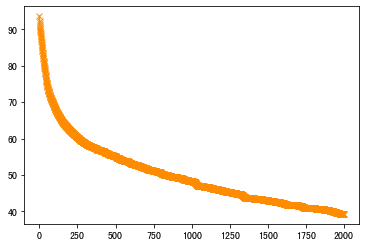

In [12]:
#hubei
param_path=''
i=0
data=read_data(paths[i])
city_name=citys[i]
# param_path=param_paths_yes[i]
N=0
if i == 3:
    N = (max(data['E']) + max(data['I']) + max(data['cured']) + max(data['dead'])) * 100.
else :
    N = N_inits[i]

model_city_date_path = train_with_city_data(data,N,datetime,city_name,max_epoches=2000,is_train=True,load_param_save=True,lr_init=0.00001,param_path=param_path)

#34695
#GT:31728
32633

[  258   363   425   495   572   618   698  1590  1905  2261  2639  3215
  4109  5142  6384  8351 10117 11618 13603 14982 16902 18454 19558 32994
 35991 37914]
data: [0.3335034971110705, 0.34401779558775397, 0.35931821621013765, 0.3858025709145108, 0.4145611386836415, 0.5758835501451969, 0.42079888342360167, 0.38555643271973, 0.37306631602635254, 0.3775121677107417, 0.3753699237018115, 0.3698082590295057, 0.3703361607695495, 0.3846980966118467, 0.41822526583057906, 0.5641526832764697, 0.5477429985553476, 0.4925672462122537, 0.5104749393330326, 0.38676557794864663, 0.17152914483908852, 0.21729706918259278, 0.0846412822531233, 0.07369578737768039]
[0.11716154 0.15309129]
{'beta': 0.3912688219411964, 'gamma_2': 0.10764449995591828, 'theta': 0, 'alpha': 0.41528951885447923}


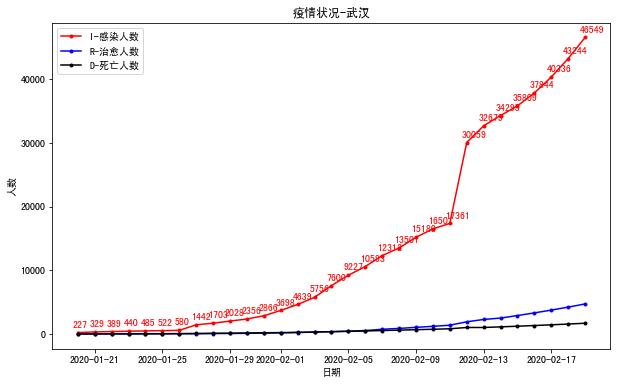

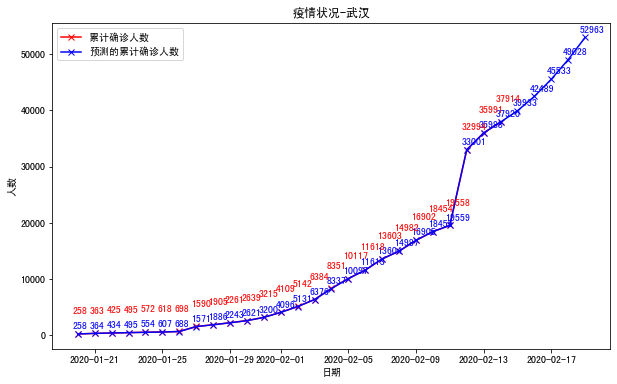

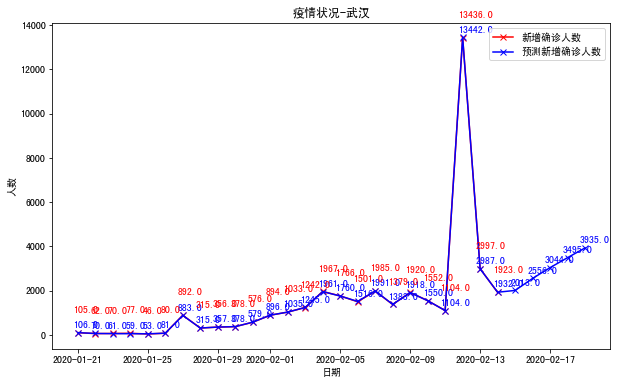

!!!!!!
N:
 [2870000 2869998 2869998 2869998 2869997 2869998 2869997 2869998 2869998
 2869998 2869996 2869997 2869998 2869997 2869998 2869998 2869997 2869998
 2869998 2869998 2869997 2869998 2869997 2869997 2869997 2869998 2869997
 2869996 2869998 2869997 2869998]


In [18]:
model = load_model_predict(model_city_date_path, data, param_pred=True, city_name=city_name)

beta: [0.5854541874172606, 0.6143281609446247, 0.6805129683105777, 0.7683934562974771, 0.7979807829794354, 0.8057531249035752, 0.7626023044285922, 0.7067465406420627, 0.6801772303849964, 0.6434030893633514, 0.6425452237405214, 0.649548119403736, 0.6325556798613838, 0.6379748605030641, 0.6519895219647508, 0.6571198703259716, 0.6808354750453767, 0.6922834650206593, 0.7230813644582164, 0.5894003984675533, 0.5487299283727921, 0.519145169652254, 0.519145169652254, 0.3117360036560615]
gamma_2: [-0.09227261723228196, -0.08212983646056894, -0.07235237002137858, -0.07255047966052587, 0.08803463140765043, 0.061393414274461926, -0.01203673763048454, 0.11610932710881265, 0.05643617742902458, 0.07760935393106404, -0.09548697386820955, -0.08499379301691859, -0.09666187812474467, 0.0979173059462475, 0.09871867472848582, 0.0848547713319267, 0.09976692396075953, 0.11997501324310483, 0.11852167228666305, 0.11976359800669738, 0.12579987504065668, 0.12085575343631191, 0.16440322785722922, 0.12089335520835

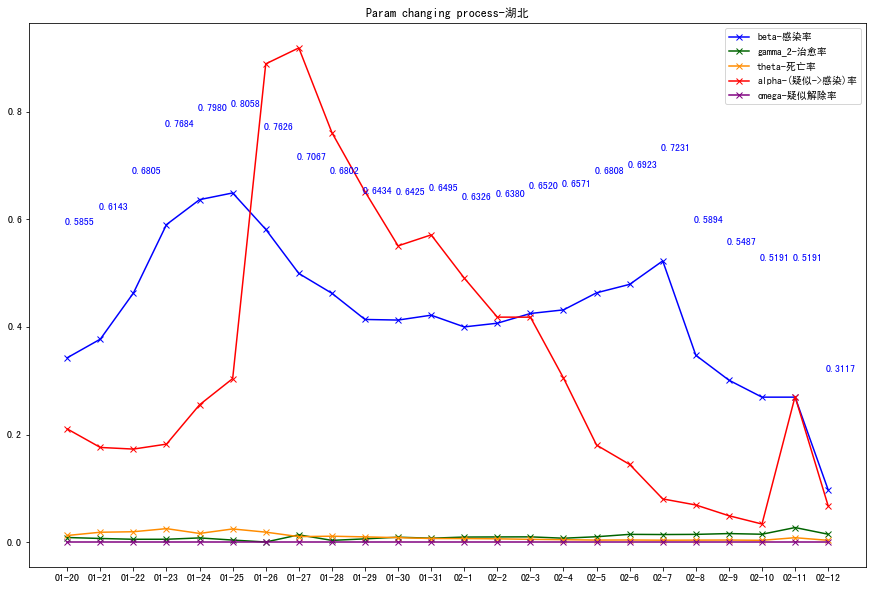

In [23]:
param = load_param(model_city_date_path)
param
# model = load_model_predict(model_city_date_path, data, param_pred=False, city_name=city_name,pred_date_len=5)
plot_param(model,city_name,data,xlen=15)

86758338778995
Training step:  1557
Loss: 5.886471721293474
Training step:  1558
Loss: 5.8862829066746905
Training step:  1559
Loss: 5.885999970052664
Training step:  1560
Loss: 5.885812909418556
Training step:  1561
Loss: 5.885528695071438
Training step:  1562
Loss: 5.885352842628912
Training step:  1563
Loss: 5.885080482281822
Training step:  1564
Loss: 5.884901804481911
Training step:  1565
Loss: 5.884615692960265
Training step:  1566
Loss: 5.884423626766058
Training step:  1567
Loss: 5.884148070332388
Training step:  1568
Loss: 5.883966396114038
Training step:  1569
Loss: 5.883681298691646
Training step:  1570
Loss: 5.883490301612696
Training step:  1571
Loss: 5.883215736626491
Training step:  1572
Loss: 5.883042556581353
Training step:  1573
Loss: 5.882755190222942
Training step:  1574
Loss: 5.882514306609853
Training step:  1575
Loss: 5.882267973526489
Training step:  1576
Loss: 5.882094916350504
Training step:  1577
Loss: 5.881826513419377
Training step:  1578
Loss: 5.8816431886

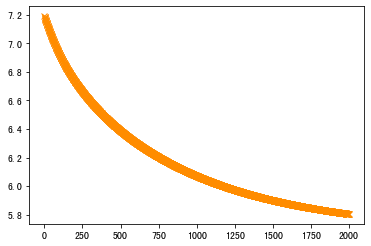

In [25]:
#wuhan

i=1
data=read_data(paths[i])
# param_path=param_paths_yes[i]
city_name=citys[i]
param_path=''
N=0
if i == 3:
    N = (max(data['E']) + max(data['I']) + max(data['cured']) + max(data['dead'])) * 100.
else :
    N = N_inits[i]

model_city_date_path = train_with_city_data(data,N,datetime,city_name,max_epoches=2000,is_train=True,load_param_save=True,lr_init=0.000001,param_path=param_path)

[  258   363   425   495   572   618   698  1590  1905  2261  2639  3215
  4109  5142  6384  8351 10117 11618 13603 14982 16902 18454 19558 32994
 35991 37914]
data: [0.33463302924993166, 0.3450662105440505, 0.35980747354565545, 0.38615590715792747, 0.41487137803737467, 0.5762005697955354, 0.42028225278294284, 0.38419344814857026, 0.37163706128387397, 0.37604429672585293, 0.37389256139533195, 0.3683418930583652, 0.3689502789738076, 0.38397342103908666, 0.41779872786628613, 0.5634416775654658, 0.547137454273595, 0.4921946452476589, 0.5103326308784111, 0.38667392078760005, 0.171441134145089, 0.21720425678223163, 0.08479293342454655, 0.07298267970041632]
[0.11663107 0.15269736]
{'beta': 0.39076509499854617, 'gamma_2': 0.10723333580126543, 'theta': 0, 'alpha': 0.4138898993086337}


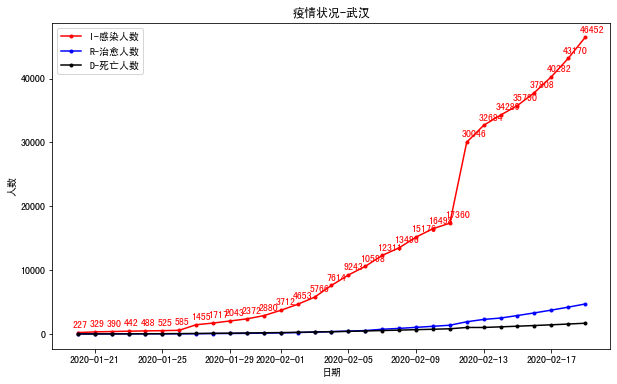

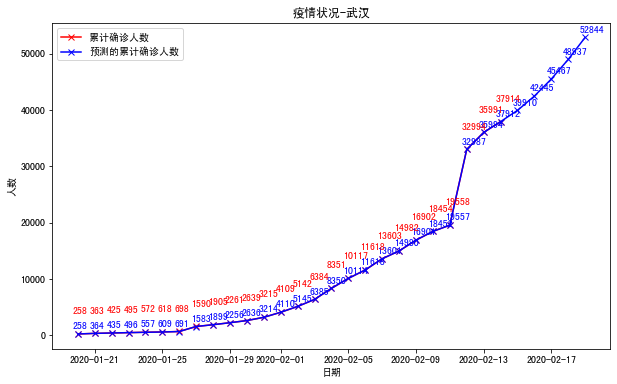

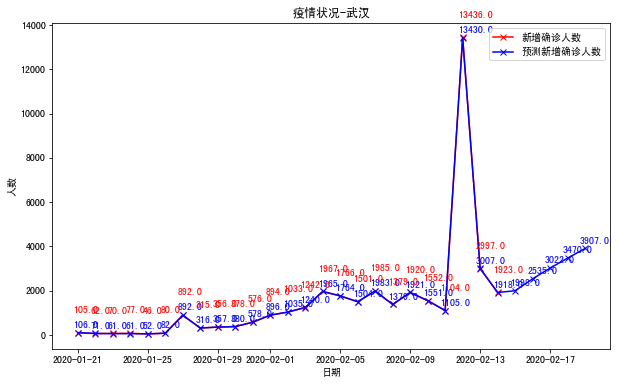

!!!!!!
N:
 [2870000 2869997 2869998 2869997 2869998 2869997 2869996 2869998 2869999
 2869998 2869997 2869998 2869999 2869999 2869998 2869998 2869996 2869998
 2869997 2869997 2869998 2869997 2869998 2869996 2869997 2869997 2869997
 2869997 2869998 2869997 2869998]
beta: [0.5784747438306461, 0.5874233656776435, 0.5998395398318249, 0.6214144407381659, 0.6441050985960092, 0.759078763894456, 0.6482917960169964, 0.6198334035437024, 0.6096204239392525, 0.6132245076037429, 0.6114675472953016, 0.6069117671114683, 0.6074127747864771, 0.6196558892152052, 0.6463735203938092, 0.7506275225206346, 0.7396874030788918, 0.701565852395667, 0.7143756930904152, 0.6218311031040503, 0.4140545062489829, 0.4660517747871277, 0.29119226195856673, 0.27015306716825616, 0.3415129080445451]
gamma_2: [-0.0855465986714526, -0.07705325085394521, -0.07749442797649386, -0.07261566858962645, -0.10851512234097434, -0.0855966144174593, -0.06496660011190389, 0.1500003638871543, 0.06474039017988502, 0.10059156633083698, 0.123

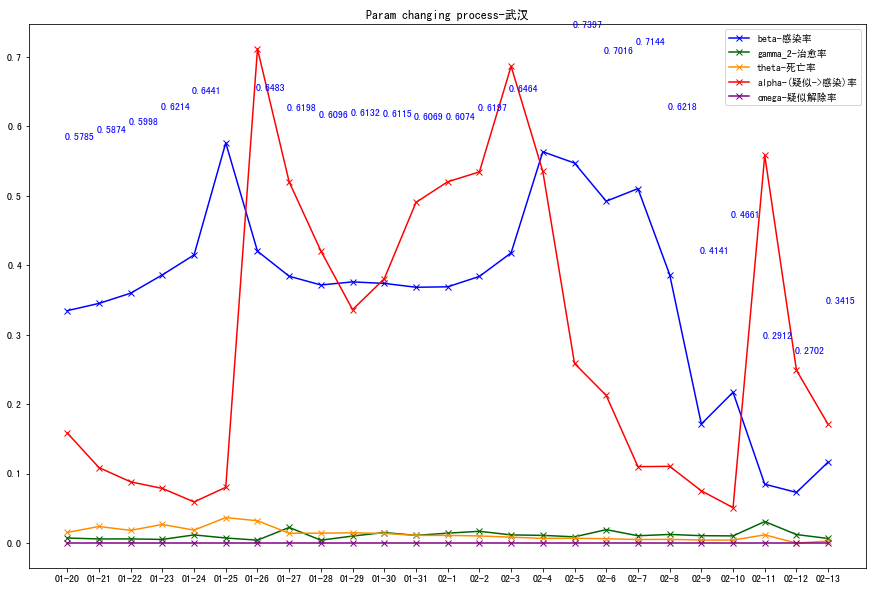

In [26]:
model = load_model_predict(model_city_date_path, data, param_pred=True, city_name=city_name)
plot_param(model,city_name,data,xlen=15)

82
Loss: 0.009292755336146728
Training step:  1583
Loss: 0.009292711106248106
Training step:  1584
Loss: 0.009292666870115644
Training step:  1585
Loss: 0.009292622693269414
Training step:  1586
Loss: 0.00929257854503991
Training step:  1587
Loss: 0.00929253444419928
Training step:  1588
Loss: 0.00929249034220773
Training step:  1589
Loss: 0.009292446303644782
Training step:  1590
Loss: 0.009292402278621464
Training step:  1591
Loss: 0.009292358319899057
Training step:  1592
Loss: 0.009292314347633437
Training step:  1593
Loss: 0.009292270424169762
Training step:  1594
Loss: 0.009292226537855811
Training step:  1595
Loss: 0.00929218270096796
Training step:  1596
Loss: 0.009292138867142053
Training step:  1597
Loss: 0.00929209508584811
Training step:  1598
Loss: 0.009292051321991188
Training step:  1599
Loss: 0.009292007626454138
Training step:  1600
Loss: 0.009291963914951608
Training step:  1601
Loss: 0.009291920254257449
Training step:  1602
Loss: 0.00929187662864789
Training step:  

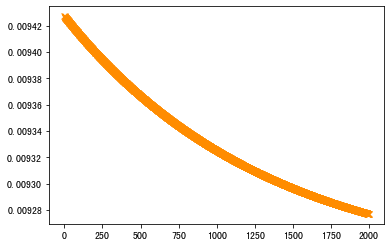

In [36]:
#shenzhen
param_path=''
i=2
data=read_data(paths[i])
city_name=citys[i]
# param_path=param_paths_yes[i]
print(param_path)
N=0
if i == 3:
    N = (max(data['E']) + max(data['I']) + max(data['cured']) + max(data['dead'])) * 100.
else :
    N = N_inits[i]

model_city_date_path = train_with_city_data(data,N,datetime,city_name,max_epoches=2000,is_train=True,load_param_save=True,lr_init=0.0000001,param_path=param_path)
# model_city_date_path = train_with_city_data(data,N,datetime,city_name)工作区中下列未跟踪的文件将会因为合并操作而被覆盖：
# load_model_predict(model_city_date_path, data, param_pred=False, city_name=city_name,pred_date_len=60)

In [37]:
model = load_model_predict(model_city_date_path, data, param_pred=True, city_name=city_name)

[ 36  49  63  86 110 170 196 226 269 289 314 334 351 364 368 375 386 391
 400 406]
data: [0.39013888977802796, 0.4048667986179511, 0.4261314611664443, 0.4372173067333068, 0.3412801704278326, 0.2108488184450334, 0.16705376462907887, 0.1352208044895523, 0.1415576176882362, 0.12492437348078632, 0.10250488232935948, 0.08095507207027125, 0.05784705645621187, 0.06837867455225154, 0.07104099539666198, 0.05737105239833538, 0.081707804223031, 0.0817020964252508]
[0.05629519 0.03853012]
     gamma_2
1  -0.007879
2  -0.021651
3   0.000001
4  -0.000001
5   0.006004
6  -0.005969
7   0.022576
8  -0.011028
9  -0.000712
10  0.009260
11  0.008706
12 -0.028831
13  0.045045
14 -0.013975
15  0.000251
16  0.015503
17 -0.007262
18 -0.001936
     gamma_2
2  -0.013772
3   0.021652
4  -0.000002
5   0.006005
6  -0.011972
7   0.028545
8  -0.033604
9   0.010316
10  0.009972
11 -0.000555
12 -0.037536
13  0.073876
14 -0.059020
15  0.014226
16  0.015251
17 -0.022765
18  0.005326
           theta
1  -6.252600e-08
2  

ValueError: sample size is too short to use selected regression component

[  291   440   571   830  1287  1975  2744  4515  5974  7711  9692 11791
 14380 17205 20438 24324 28018 31161 34546 37198 40171 42638 44653 59804
 63851 66492]


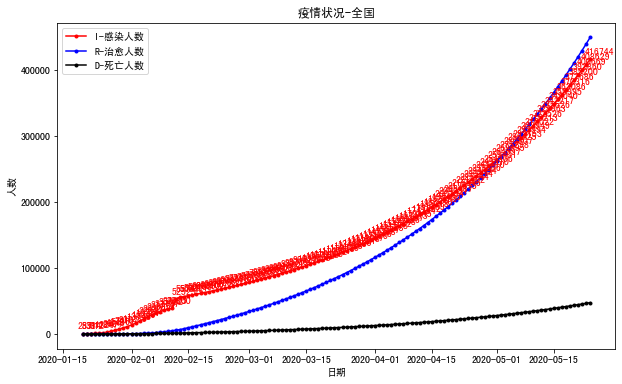

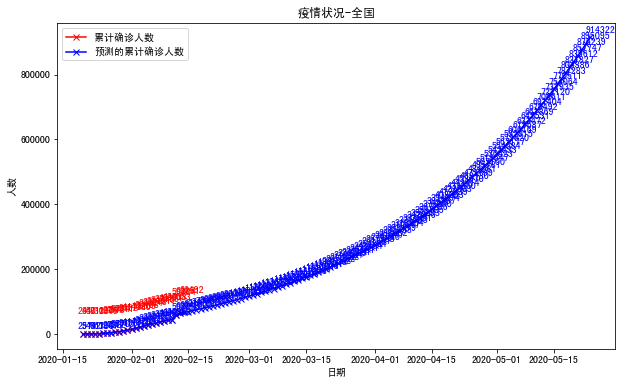

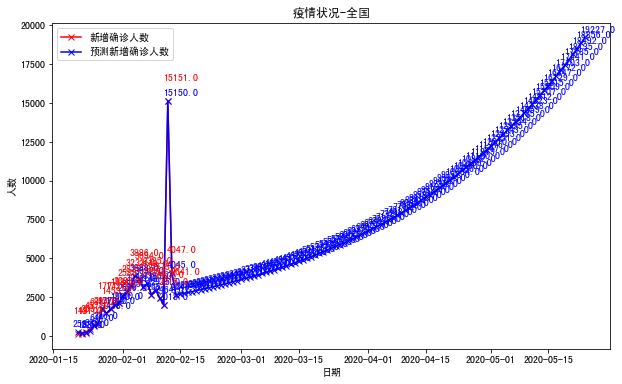

!!!!!!
N:
 [75768300 75768297 75768298 75768297 75768298 75768297 75768298 75768298
 75768297 75768297 75768297 75768298 75768298 75768298 75768297 75768299
 75768297 75768297 75768298 75768297 75768299 75768296 75768299 75768298
 75768296 75768298 75768297 75768297 75768297 75768297 75768298 75768297
 75768298 75768298 75768298 75768297 75768299 75768299 75768297 75768297
 75768297 75768297 75768297 75768297 75768299 75768297 75768298 75768298
 75768298 75768297 75768298 75768297 75768298 75768297 75768298 75768298
 75768298 75768297 75768298 75768296 75768297 75768297 75768296 75768297
 75768297 75768298 75768298 75768297 75768297 75768297 75768297 75768297
 75768297 75768298 75768297 75768297 75768297 75768297 75768298 75768297
 75768298 75768297 75768298 75768297 75768297 75768298 75768297 75768297
 75768297 75768298 75768298 75768298 75768297 75768297 75768297 75768296
 75768297 75768298 75768297 75768298 75768297 75768297 75768297 75768297
 75768298 75768298 75768298 75768299 757

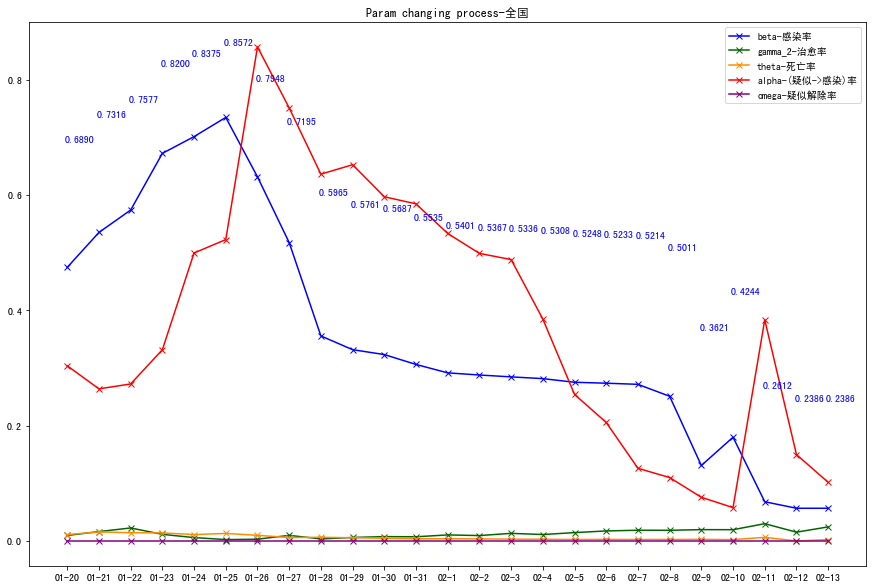

In [95]:
model = load_model_predict(model_city_date_path, data, param_pred=False, city_name=city_name,pred_date_len=100)
plot_param(model,city_name,data,xlen=15)

In [93]:
#china

i=3
data=read_data(paths[i])
city_name=citys[i]
# param_path='models/'+'china/02-14'
param_path=''
N=0
if i == 3:
    N = (max(data['E']) + max(data['I']) + max(data['cured']) + max(data['dead'])) * 100.
else :
    N = N_inits[i]
model_city_date_path = train_with_city_data(data,N,datetime,city_name,max_epoches=1000,is_train=False,load_param_save=True,lr_init=0.0000001,param_path=param_path)
# model_city_date_path = train_with_city_data(data,N,datetime,city_name)
# load_model_predict(model_city_date_path, data, param_pred=True, city_name=city_name)

cured_ratio: 11.920625764323125
dead_ratio: 40.5739417262232
{'beta': [0.6889996867255491, 0.7316181654552859, 0.7576666848732054, 0.8199667573063734, 0.8375078919416953, 0.8571678511309954, 0.794753280269639, 0.71951030969753, 0.5964597216863494, 0.5761416156530534, 0.5687379776484327, 0.553470789803031, 0.5401119314355372, 0.5366704729930417, 0.5336299464595502, 0.5307914865586381, 0.5248074196538212, 0.5232753371859427, 0.5213733263568544, 0.5011346772715173, 0.36207562285252815, 0.4244075644184685, 0.26121433774558567, 0.23862274227754926, 0.23862269471232317], 'theta': [0.10614121447459234, -0.1258889601176279, -0.12065305311209949, -0.11890842504519358, -0.10650145295907998, -0.11522232794022164, -0.10011091093031028, 0.07836113369212418, -0.08127173169058696, -0.07599274661377743, -0.07024879292547181, 0.06323295128829319, 0.06434916503717984, -0.06252397468570842, 0.05792031910808673, 0.05640830315144554, 0.05268042888706439, -0.05446980252335747, 0.052926419542557224, 0.053619

[  291   440   571   830  1287  1975  2744  4515  5974  7711  9692 11791
 14380 17205 20438 24324 28018 31161 34546 37198 40171 42638 44653 59804
 63851 66492]
data: [0.47472063385277263, 0.5352652096233419, 0.574058733289566, 0.6723454050837064, 0.7014193893921034, 0.7347366434697481, 0.6316327008940988, 0.5176950173136828, 0.3557641428526652, 0.33193910647868957, 0.32346283311531915, 0.3063298625132557, 0.29172084709792573, 0.288015145528862, 0.28476086899395603, 0.2817395517086865, 0.2754227777985267, 0.27381702872763447, 0.27183009583792267, 0.2511359170908518, 0.1310987222196237, 0.18012174036152695, 0.06823290539442446, 0.05694079043177058]
[-0.0646286  -0.08753341]
     gamma_2
1   0.006702
2   0.006297
3  -0.011100
4  -0.005593
5  -0.003490
6   0.000677
7   0.006645
8  -0.006131
9   0.002512
10  0.001459
11 -0.000266
12  0.003210
13 -0.001116
14  0.003831
15 -0.002045
16  0.003340
17  0.002883
18  0.001254
19 -0.000116
20  0.001137
21 -0.000096
22  0.010406
23 -0.014721
24  0.0

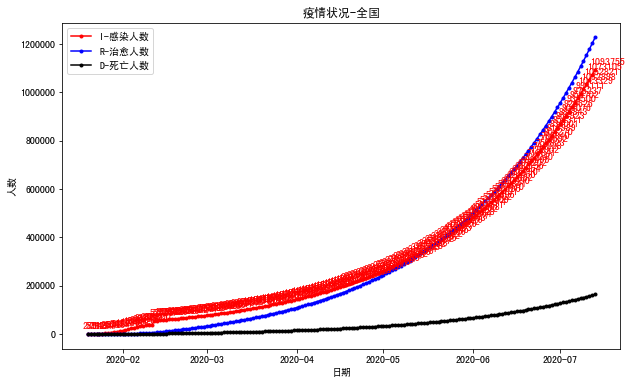

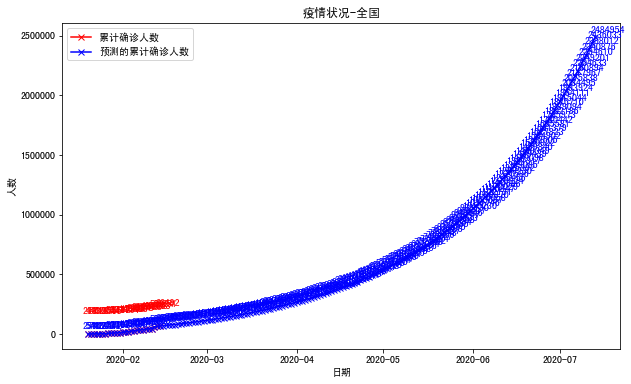

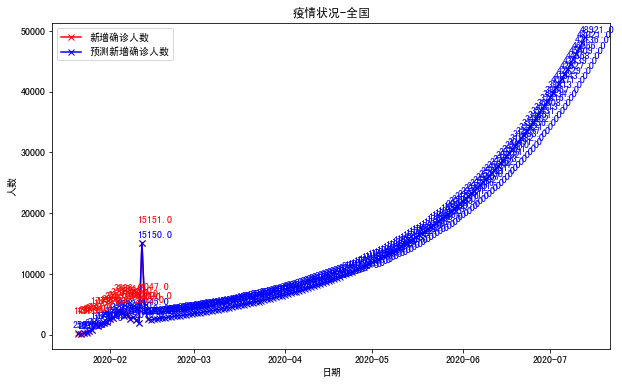

!!!!!!
N:
 [75768300 75768297 75768298 75768297 75768298 75768297 75768298 75768298
 75768297 75768297 75768297 75768298 75768298 75768298 75768297 75768299
 75768297 75768297 75768298 75768297 75768299 75768296 75768299 75768298
 75768296 75768298 75768298 75768297 75768297 75768298 75768297 75768297
 75768299 75768297 75768298 75768297 75768297 75768297 75768297 75768297
 75768298 75768297 75768297 75768296 75768298 75768298 75768298 75768298
 75768297 75768297 75768297 75768297 75768298 75768298 75768297 75768298
 75768298 75768297 75768298 75768298 75768297 75768298 75768297 75768297
 75768297 75768298 75768297 75768297 75768298 75768298 75768298 75768297
 75768297 75768298 75768297 75768297 75768297 75768297 75768298 75768297
 75768298 75768298 75768297 75768298 75768297 75768298 75768298 75768298
 75768298 75768297 75768298 75768297 75768297 75768298 75768297 75768298
 75768298 75768298 75768297 75768297 75768297 75768298 75768297 75768298
 75768299 75768298 75768298 75768298 757

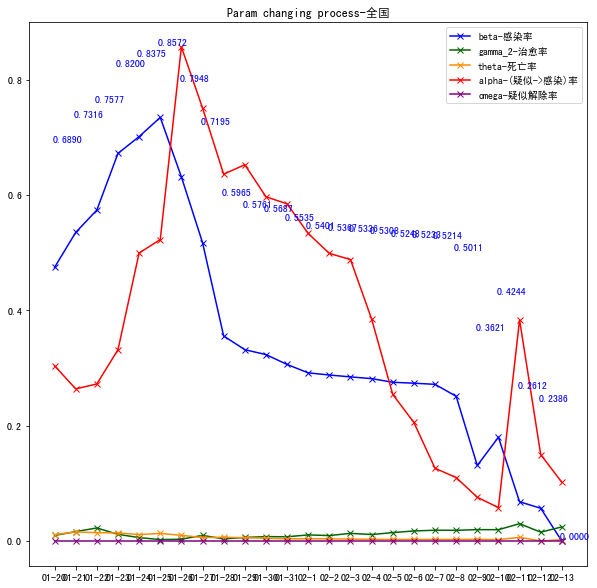

In [94]:
model = load_model_predict(model_city_date_path, data, param_pred=True, city_name=city_name, pred_date_len=150)
plot_param(model,city_name,data,xlen=10)

In [50]:
def format_output(model_city_date_path, data, param_pred=False, city_name='深圳',c='confirmed', features=['I','cured','dead'], pred_date_len=5, data_dict={'累计':{},'新增':{}},data_dict_report={'累计':{},'新增':{}}):
    I_name,recover_name,dead_name = features
    model_pt = os.path.join(model_city_date_path,'model.pt')
    model = torch.load(model_pt)
    I = model.I_tensor_cur
    R = model.R_tensor_cur
    D = model.D_tensor_cur
    I_pred_old = (I.detach().numpy()).astype(np.int)
    R_pred_old = (R.detach().numpy()).astype(np.int)
    D_pred_old = (D.detach().numpy()).astype(np.int)

    confirm_pred = cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
    confirm_origin = get_data_acc_confirm(data,c=c)
    # print(confirm_origin)
    new_confirm = cal_new_confirm(np.array(data[I_name]),np.array(data[recover_name]),np.array(data[dead_name]))
    cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
    new_confirm_pred = cal_new_confirm(I_pred_old,R_pred_old,D_pred_old)

    if param_pred:
        beta = []
        theta = []
        gamma_2 = []
        alpha = []
        for i in range(len(model.SEIR_cells)):
            beta.append(model.SEIR_cells[i].beta.detach().numpy()[0])
            gamma_2.append(model.SEIR_cells[i].gamma_2.detach().numpy()[0])
            theta.append(model.SEIR_cells[i].theta.detach().numpy()[0])
            alpha.append(model.SEIR_cells[i].alpha.detach().numpy()[0])
        # if city_name=='深圳':
        #     theta=get_recent_curve(theta)
        # print(len(theta))
        param = model.param_pred(beta,gamma_2,theta,alpha)

        print(param)
        S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(param=param, pred_date_len = pred_date_len)
    else:
        S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(pred_date_len = pred_date_len)

    I_pred_new = (I_pred_tensor.detach().numpy()).astype(np.int)
    R_pred_new = (R_pred_tensor.detach().numpy()).astype(np.int)
    D_pred_new = (D_pred_tensor.detach().numpy()).astype(np.int)
    I_pred_total = np.concatenate((I_pred_old,I_pred_new),axis=0)
    R_pred_total = np.concatenate((R_pred_old,R_pred_new),axis=0)
    D_pred_total = np.concatenate((D_pred_old,D_pred_new),axis=0)

    # plot_SEIRD(data, I=I_pred_total, R=R_pred_total, D=D_pred_total, city=city_name, pred_date_len=pred_date_len)

    confirm_pred = cal_acc_confirm(I_pred_total,R_pred_total,D_pred_total)
    confirm_origin = get_data_acc_confirm(data,c=c)
    # plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name, pred_date_len=pred_date_len)

    new_confirm_pred_total = cal_new_confirm(I_pred_total,R_pred_total,D_pred_total)
    new_confirm_pred_total
    # plot_daily_new(data, new_confirm, new_confirm_pred_total, city=city_name, pred_date_len=pred_date_len)

    T_name = 'time'
    time_val = data[T_name].values

    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1, pred_date_len + 1):
        pred_time.append(max_time_val + np.timedelta64(i, 'D'))
    if pred_time == []:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time), axis=0)
    # pd.to_datetime()
    def format_datetime(x):
        xd = x.date()
        fxd = ''
        if xd.month<10 and xd.day<10:
            fxd = f'0{xd.month}-0{xd.day}'
        elif xd.month<10 and xd.day>=10: 
            fxd = f'0{xd.month}-{xd.day}'
        else:
            fxd = f'{xd.month}-{xd.day}'
        return fxd
    dates_list = [format_datetime(pd.to_datetime(d)) for d in merge_time]
    data_dict_report['累计'][city_name] = dict.fromkeys(dates_list)
    data_dict_report['新增'][city_name] = dict.fromkeys(dates_list)
    temp=[]
    for i,p in enumerate(confirm_pred):
        data_dict['累计'][city_name].append([dates_list[i],p])
        data_dict_report['累计'][city_name][dates_list[i]]=p
    for i,p in enumerate(new_confirm_pred_total):
        data_dict['新增'][city_name].append([dates_list[i+1],p])
        data_dict_report['新增'][city_name][dates_list[i+1]]=p
    return data_dict,data_dict_report

date_time='02-15'
time='0214'
citys=['湖北','武汉','全国','深圳']
paths=['./ncov/data/hubei_截至'+time+'_24时.csv','./ncov/data/wuhan_截至'+time+'_24时.csv','./ncov/data/nation_截至'+time+'_24时.csv','./ncov/data/shenzhen_截至'+time+'_24时.csv']
modelpath=['./models/hubei/'+date_time,'./models/wuhan/'+date_time,'./models/china/'+date_time,'./models/shenzhen/'+date_time]
# starts_date=['2020-01-20','2020-01-20','2020-01-20','2020-01-26'] #深圳从2020-01-26开始
# end_date=get_today_date()
def init_data_dict(citys):
    data_dict = dict.fromkeys(['累计','新增'])
    for k in data_dict.keys():
        data_dict[k] = dict.fromkeys(citys)
        for dc in data_dict[k].keys():
            data_dict[k][dc]=[]
    return data_dict

data_dict = init_data_dict(citys)
data_dict_report = init_data_dict(citys)
for i in range(len(citys)):
    city_name=citys[i]
    print(city_name)
    data=read_data(paths[i])
    if city_name=='深圳':
        data_dict,data_dict_report = format_output(modelpath[i], data, param_pred=False, city_name=city_name,features=['I','cured','dead'], pred_date_len=5, data_dict=data_dict,data_dict_report=data_dict_report)
    else:
        data_dict,data_dict_report = format_output(modelpath[i], data, param_pred=True, city_name=city_name,features=['I','cured','dead'], pred_date_len=5, data_dict=data_dict,data_dict_report=data_dict_report)
print(data_dict)
# print(data_dict_report)

湖北
data: [0.3373333089228468, 0.37285446958908885, 0.4593200142235407, 0.587890716214895, 0.6338718765379777, 0.6456797421734612, 0.5771027866565087, 0.4943337104062707, 0.4568643432399968, 0.4080284892907158, 0.40659483592361817, 0.4159849760100504, 0.39454577357983894, 0.4012868948189337, 0.4195651423975875, 0.4253100064532348, 0.4570332731707808, 0.4733211999512464, 0.5167393442102807, 0.34043252704300464, 0.29442086722998784, 0.26300780790327427, 0.24553497680308686, 0.22618420053226415]
[0.2158447  0.20919236]
     gamma_2
1  -0.001904
2  -0.001616
3  -0.000092
4   0.002636
5  -0.004156
6  -0.003938
7   0.014049
8  -0.011561
9   0.002745
10  0.003009
11 -0.000669
12  0.001529
13  0.000349
14 -0.000268
15 -0.002129
16  0.002602
17  0.004431
18 -0.000291
19  0.000164
20  0.001640
21 -0.001290
22  0.012466
23 -0.011188
24 -0.002016
       theta
1   0.006219
2   0.000694
3   0.005609
4  -0.009166
5   0.008504
6  -0.006108
7  -0.008542
8  -0.000164
9  -0.000196
10 -0.001583
11 -0.00149

In [51]:
print(data_dict_report)

{'累计': {'湖北': {'01-20': 270, '01-21': 416, '01-22': 528, '01-23': 642, '01-24': 783, '01-25': 1035, '01-26': 1397, '01-27': 2685, '01-28': 3517, '01-29': 4568, '01-30': 5795, '01-31': 7150, '02-1': 9081, '02-2': 11179, '02-3': 13524, '02-4': 16682, '02-5': 19656, '02-6': 22114, '02-7': 24948, '02-8': 27104, '02-9': 29624, '02-10': 31729, '02-11': 33362, '02-12': 48206, '02-13': 51982, '02-14': 54405, '02-15': 56806, '02-16': 59513, '02-17': 62438, '02-18': 65512, '02-19': 68690}, '武汉': {'01-20': 258, '01-21': 364, '01-22': 435, '01-23': 496, '01-24': 557, '01-25': 609, '01-26': 691, '01-27': 1583, '01-28': 1899, '01-29': 2256, '01-30': 2636, '01-31': 3214, '02-1': 4110, '02-2': 5145, '02-3': 6385, '02-4': 8350, '02-5': 10114, '02-6': 11618, '02-7': 13601, '02-8': 14980, '02-9': 16901, '02-10': 18452, '02-11': 19557, '02-12': 32987, '02-13': 35994, '02-14': 37912, '02-15': 39910, '02-16': 42445, '02-17': 45467, '02-18': 48937, '02-19': 52844}, '全国': {'01-20': 291, '01-21': 549, '01-22':

In [53]:
# data_dict = init_data_dict(citys)
# data_dict_report = init_data_dict(citys)
# for i in range(len(citys)):
#     city_name=citys[i]
#     data=read_data(paths[i])
#     data_dict,data_dict_report = format_output(modelpath[i], data, param_pred=True, city_name=city_name,features=['I','cured','dead'], pred_date_len=5, data_dict=data_dict,data_dict_report=data_dict_report)
print('SEIRD-ARIMA:')
for i in range(len(citys)):
    city_name=citys[i]
    s = '{}:{}'.format(city_name,data_dict_report['累计'][city_name]['02-15'])
    print(s)
# print('SEIRD')
# for i in range(len(citys)):
#     city_name=citys[i]
#     if city_name=='全国':
#         continue
#     s = '{}:{}'.format(city_name,data_dict_report_2['累计'][city_name]['02-13'])
#     print(s)


SEIRD-ARIMA:
湖北:56806
武汉:39910
全国:68963
深圳:415


In [ ]:
for i in range(len(citys)):
    city_name=citys[i]
    if city_name=='全国':
        continue
    data=read_data(paths[i])
    if city_name=='深圳':
        data_dict = format_output(modelpath[i], data, param_pred=False, city_name=city_name,features=['I','cured','dead'], pred_date_len=5, data_dict=data_dict)
    else:
        data_dict = format_output(modelpath[i], data, param_pred=True, city_name=city_name,features=['I','cured','dead'], pred_date_len=5, data_dict=data_dict)

In [ ]:
citys=['湖北','武汉','全国','深圳']
def init_data_dict(citys):
    data_dict = dict.fromkeys(['累计','新增'])
    for k in data_dict.keys():
        data_dict[k] = dict.fromkeys(citys)
        for dc in data_dict[k].keys():
            data_dict[k][dc]=[]
    return data_dict

data_dict = init_data_dict(citys)
data_dict

In [86]:
from pmdarima.arima import auto_arima
data_arima = [0.33463302924993166, 0.3450662105440505, 0.35980747354565545, 0.38615590715792747, 0.41487137803737467, 0.5762005697955354, 0.42028225278294284, 0.38419344814857026, 0.37163706128387397, 0.37604429672585293, 0.37389256139533195, 0.3683418930583652, 0.3689502789738076, 0.38397342103908666, 0.41779872786628613, 0.5634416775654658, 0.547137454273595, 0.4921946452476589, 0.5103326308784111, 0.38667392078760005, 0.171441134145089, 0.21720425678223163, 0.08479293342454655, 0.07298267970041632]

stepwise_model = auto_arima(data_arima, trace=False, error_action='ignore', suppress_warnings=True)

In [87]:
print(stepwise_model.aic())

-45.65237634793665


In [88]:
stepwise_model.fit(data_arima)

ARIMA(maxiter=50, method='lbfgs', order=(1, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 1),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [73]:
future_forecast = stepwise_model.predict(n_periods=20)
future_forecast

array([0.116597  , 0.15263971, 0.18242527, 0.20703994, 0.22738141,
       0.24419153, 0.25808334, 0.26956348, 0.27905063, 0.28689077,
       0.29336984, 0.29872411, 0.30314886, 0.30680546, 0.30982726,
       0.31232446, 0.31438814, 0.31609356, 0.31750291, 0.31866759])

In [76]:
plot_array = np.concatenate((data_arima,future_forecast),axis=0)
plot_array

array([0.33463303, 0.34506621, 0.35980747, 0.38615591, 0.41487138,
       0.57620057, 0.42028225, 0.38419345, 0.37163706, 0.3760443 ,
       0.37389256, 0.36834189, 0.36895028, 0.38397342, 0.41779873,
       0.56344168, 0.54713745, 0.49219465, 0.51033263, 0.38667392,
       0.17144113, 0.21720426, 0.08479293, 0.07298268, 0.116597  ,
       0.15263971, 0.18242527, 0.20703994, 0.22738141, 0.24419153,
       0.25808334, 0.26956348, 0.27905063, 0.28689077, 0.29336984,
       0.29872411, 0.30314886, 0.30680546, 0.30982726, 0.31232446,
       0.31438814, 0.31609356, 0.31750291, 0.31866759])

In [83]:
from plotly import graph_objs as go
fig = go.Figure()
fig.add_trace(go.Scatter(
                x=list(range(len(data_arima))),
                y=data_arima,
                name="Actual Value",
                line_color='deepskyblue',
                opacity=0.8))
fig.add_trace(go.Scatter(
                x=list(range(len(data_arima)+len(future_forecast)))[len(data_arima):],
                y=future_forecast,
                name="Forecast Value",
                line_color='dimgray',
                opacity=0.8))

fig.show()